In [1]:
%cd /content/drive/MyDrive/neuroimaging

/content/drive/MyDrive/neuroimaging


In [2]:
import requests
import zipfile
import pandas as pd
import numpy as np
import os
import nibabel
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython import display
from scipy.stats.stats import pearsonr   

The following cell downloads the dataset for this notebook, which contains functional and structural MRI scans of a single subject listening to "by-syllabic" words.

In [3]:
# Define the URL of the data and download it using the Requests libary
url = 'http://www.fil.ion.ucl.ac.uk/spm/download/data/MoAEpilot/MoAEpilot.zip'
data = requests.get(url)

# Check if the targed folder for storing the data already exists. If not create it and save the zip file.
if os.path.exists('./fMRI_data') == False:
    os.mkdir('fMRI_data')
    
open('./fMRI_data/data.zip', 'wb').write(data.content)

# Un-zip the file
zip_ref = zipfile.ZipFile('./fMRI_data/data.zip', 'r')
zip_ref.extractall('./fMRI_data/')
zip_ref.close()

# Visualization

## Structural MRI data

To load the data, we will utilize the [NiBabel](https://nipy.org/nibabel/) library, which "provides read +/- write access to some common medical and neuroimaging file formats" (quoted from the official site of the library).

As shown from the output in the following cell, there are two structural files corresponding the the structural MRI scan, one ending with ".hdr" and another with ".img". Nilabel takes in the .hdr file as input and will return a np.array of the scan.

In [4]:
# Find all files in the structural data folder
data_path = './fMRI_data/sM00223/'
files = os.listdir(data_path)
print(files)

['sM00223_002.hdr', 'sM00223_002.img']


In [5]:
data = nibabel.load("./fMRI_data/sM00223/sM00223_002.hdr").get_fdata()
print("As expected this is a numpy array", type(data))
print("The data is a 4D array, but the final dimension is not necessary, the shape is", data.shape)
data = data.squeeze()
print("We have removed the final dimension of the array, now giving us a 3D array with shape", data.shape)

As expected this is a numpy array <class 'numpy.ndarray'>
The data is a 4D array, but the final dimension is not necessary, the shape is (256, 256, 54, 1)
We have removed the final dimension of the array, now giving us a 3D array with shape (256, 256, 54)


Now, lets visualize the scan:

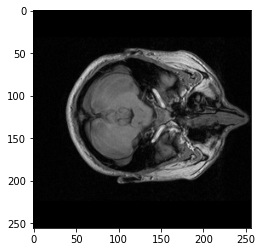

In [6]:
plt.imshow(data[:, :, 10], 'gray')

The image appears to be a head (as expected), but the direction of the head seems to be pointing to the right. We may want it to be pointing upwards instead so let's rotate it 90 degrees counter clockwise!

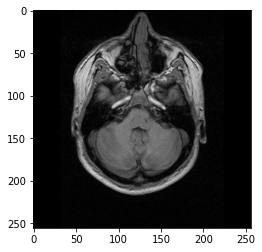

In [7]:
data = np.rot90(data, 1)
plt.imshow(data[:, :, 10], 'gray')

From the above, we can only see a single slice of the scan due to the limitation that we are projecting a volumetric (3D) image onto a 2D plane. A way to get a better visualization of the scan is to create an animation of the scan, slice by slice.

In [8]:
def animate(scan):
    fig = plt.figure()

    def f(idx):
        return scan[:, :, -idx]

    im = plt.imshow(f(0), 'gray', animated=True)

    def updatefig(frame):
        im.set_array(f(frame))
        return im,

    ani = animation.FuncAnimation(fig, updatefig, frames = 54, blit=True)

    video = ani.to_html5_video()
    html = display.HTML(video)
    display.display(html)
    plt.close()

animate(data)


Another option is to plot multiple slices side by side, like this

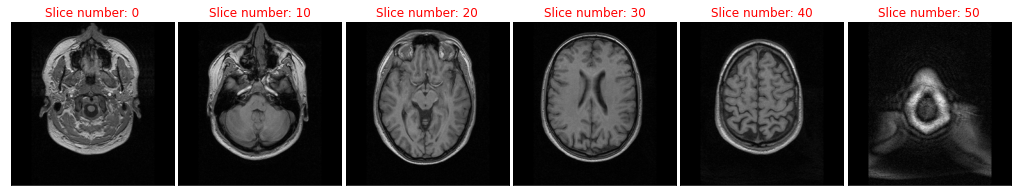

In [9]:
fig, ax = plt.subplots(1, 6, figsize=[18, 3])

n = 0
slice = 0
for _ in range(6):
    ax[n].imshow(data[:, :, slice], 'gray')
    ax[n].set_xticks([])
    ax[n].set_yticks([])
    ax[n].set_title('Slice number: {}'.format(slice), color='r')
    n += 1
    slice += 10
    
fig.subplots_adjust(wspace=0, hspace=0)

Structural MRIs provide spatial information about the brain/head of the subject, but we do not get any information about the activities of the brain, namely the "BOLD" signals over time. This is where the fMRI comes in.

## Functional MRI

According to the [README.txt](http://www.fil.ion.ucl.ac.uk/spm/download/data/MoAEpilot/README.txt) of the dataset, the fMRI are made up of 64 columns, 64 rows, 64 slices, and 96 volumes.

In [10]:
x_size = y_size = n_slice = 64
n_volumes = 96

# Find all files in the data folder
data_path = './fMRI_data/fM00223/'
files = os.listdir(data_path)

# Read in the data and organize it with respect to the acquisition parameters
data_all = []
for data_file in files:
    if data_file[-3:] == 'hdr':
        data = nibabel.load(data_path + data_file).get_data()        
        data_all.append(data.reshape(x_size, y_size, n_slice))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavi

In [11]:
print("Let's check if we have loaded the data in correctly...")
print(f"There are {len(data_all)} volumes")
print(f"Each volume is of dimension {data_all[0].shape}")

Let's check if we have loaded the data in correctly...
There are 96 volumes
Each volume is of dimension (64, 64, 64)


There are now 4 dimensions for our data, which means we will have to visualize them in a slightly different way. The following visualizations of the fMRI are taken from the first volume, for each of the coronal, transversal, and sagittal planes, respectively.

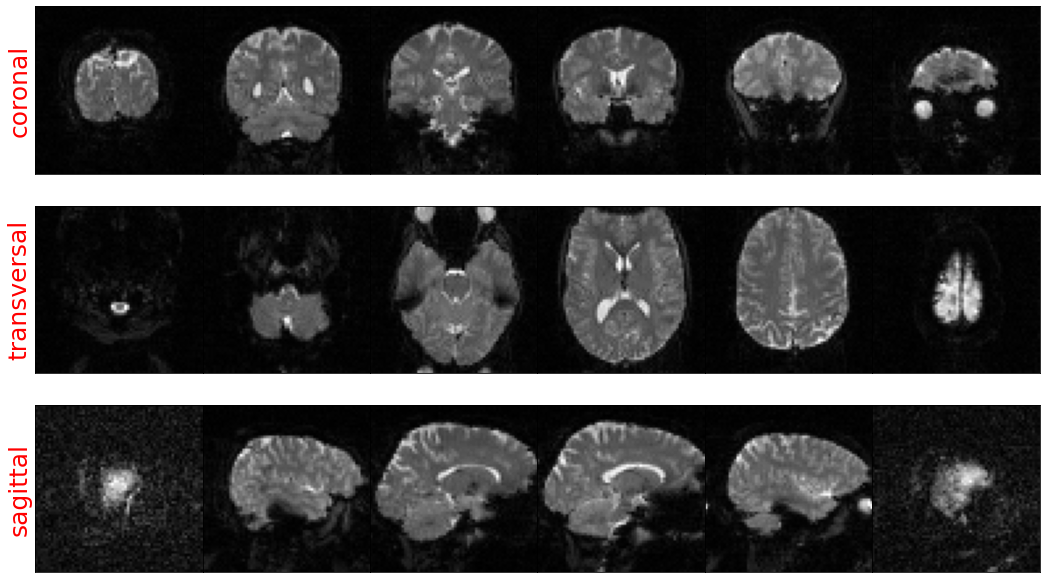

In [12]:
# Create a 3x6 subplot 
fig, ax = plt.subplots(3, 6, figsize=[18, 11])

# Orgaize the data for visualisation in the coronal plane
coronal = np.transpose(data_all, [1, 3, 2, 0])
coronal = np.rot90(coronal, 1)

# Orgaize the data for visualisation in the transversal plane
transversal = np.transpose(data_all, [2, 1, 3, 0])
transversal = np.rot90(transversal, 2)

# Orgaize the data for visualisation in the sagittal plane
sagittal = np.transpose(data_all, [2, 3, 1, 0])
sagittal = np.rot90(sagittal, 1)

# Plot some of the images in different planes
n = 10
for i in range(6):
    ax[0][i].imshow(coronal[:, :, n, 0], cmap='gray')
    ax[0][i].set_xticks([])
    ax[0][i].set_yticks([])
    if i == 0:
        ax[0][i].set_ylabel('coronal', fontsize=25, color='r')
    n += 10
    
n = 5
for i in range(6):
    ax[1][i].imshow(transversal[:, :, n, 0], cmap='gray')
    ax[1][i].set_xticks([])
    ax[1][i].set_yticks([])
    if i == 0:
        ax[1][i].set_ylabel('transversal', fontsize=25, color='r')
    n += 10

n = 5
for i in range(6):
    ax[2][i].imshow(sagittal[:, :, n, 0], cmap='gray')
    ax[2][i].set_xticks([])
    ax[2][i].set_yticks([])
    if i == 0:
        ax[2][i].set_ylabel('sagittal', fontsize=25, color='r')
    n += 10

fig.subplots_adjust(wspace=0, hspace=0)

Similar to sMRI, we can also animate the visualization

In [13]:
def animate_fmri(plane, volume):
    fig = plt.figure()
    assert plane in ["coronal", "transversal", "sagittal"]
    if plane == "coronal":
        cut = np.transpose(data_all, [1, 3, 2, 0])
        cut = np.rot90(cut, 1) 
    elif plane == "transversal":
        cut = np.transpose(data_all, [2, 1, 3, 0])
        cut = np.rot90(cut, 2)
    elif plane == "sagittal":
        cut = np.transpose(data_all, [2, 3, 1, 0])
        cut = np.rot90(cut, 1)

    def f(idx):
        return cut[:, :, idx, volume]

    im = plt.imshow(f(0), cmap='gray')

    def updatefig(frame):
        im.set_array(f(frame))
        return im,

    ani = animation.FuncAnimation(fig, updatefig, frames=64, blit=True)

    video = ani.to_html5_video()
    html = display.HTML(video)
    display.display(html)
    plt.close()

animate_fmri("coronal", 0)
animate_fmri("transversal", 0)



To visualize the temporal dimension, we can pick any voxel within the scan and track how its signal varies with time. However, it is difficult to learn anythign meaningful from such a plot.

In [14]:
# Rearrange and reshape data for export
data_all = np.transpose(data_all, [3, 2, 1, 0])
data_all = np.reshape(data_all, [n_slice, y_size*x_size, n_volumes])

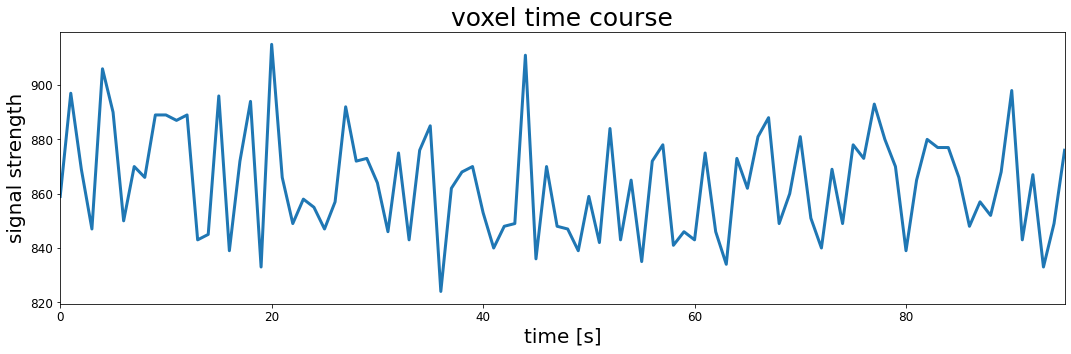

In [15]:
# Create an empty plot with defined aspect ratio
fig, ax = plt.subplots(1, 1, figsize=[18, 5])

# Plot the timecourse of a random voxel
ax.plot(transversal[30, 30, 35, :], lw=3)
ax.set_xlim([0, transversal.shape[3]-1])
ax.set_xlabel('time [s]', fontsize=20)
ax.set_ylabel('signal strength', fontsize=20)
ax.set_title('voxel time course', fontsize=25)
ax.tick_params(labelsize=12)


Another way we can visualise this data is to take the mean signals over the course of the scan, i.e. the mean over the 96 volumns. Let us try this with slice 36.

In [16]:
data = data_all[36]
data.shape

(4096, 96)

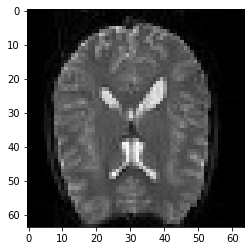

In [17]:
plt.imshow(data.mean(1).reshape(64, 64), 'gray')

# The experiement paradigm

The purpose of an fMRI scan is to locate regions within the brain that are active during a "stimulation". The data we are looking at are of a person lying in an MRI machine whilst listening to "bi-syllabic" words. Therefore, in order to proceed, we should ideally learn about how the experiements were conducted during the scannning. According the to the [README](http://www.fil.ion.ucl.ac.uk/spm/download/data/MoAEpilot/README.txt) of the data set, the experiment was carried out in blocks, each block lasting 7 seconds and corresponds to 6 volumes. The condition for successive blocks alternated between rest and
auditory stimulation, starting with rest. Auditory stimulation was
bi-syllabic words presented binaurally at a rate of 60 per minute.

To put it simply, the first 6 volumes corresponds to rest period, then volume 7 to 12 corresponds to a preiod of auditory stimulation, and so on. In total, there were 8 blocks of rest preiods and 8 blocks of stimulation periods.




In [18]:
# These are the main parameters of the fMRI scan and experimental desgin
block_design    = ['rest', 'stim']
block_size      = 6
block_RT        = 7
block_total     = 16
block_length    = block_size*block_RT

acq_num         = block_size*block_total
print('acq_num:', acq_num)
data_time       = block_length*block_total
print('\ndata_time:', data_time)
data_time_vol   = np.arange(acq_num)*block_RT
print('\ndata_time_vol:\n', data_time_vol)

x_size = 64
y_size = 64

acq_num: 96

data_time: 672

data_time_vol:
 [  0   7  14  21  28  35  42  49  56  63  70  77  84  91  98 105 112 119
 126 133 140 147 154 161 168 175 182 189 196 203 210 217 224 231 238 245
 252 259 266 273 280 287 294 301 308 315 322 329 336 343 350 357 364 371
 378 385 392 399 406 413 420 427 434 441 448 455 462 469 476 483 490 497
 504 511 518 525 532 539 546 553 560 567 574 581 588 595 602 609 616 623
 630 637 644 651 658 665]


With the above information, we can proceed to build our design matrix, which is our expectation of how we think the BOLD signal should be modulated throughout the session, e.g., there should be a strong correlation between the BOLD signals for regions responsible for auditory processing with the expected response graph below.

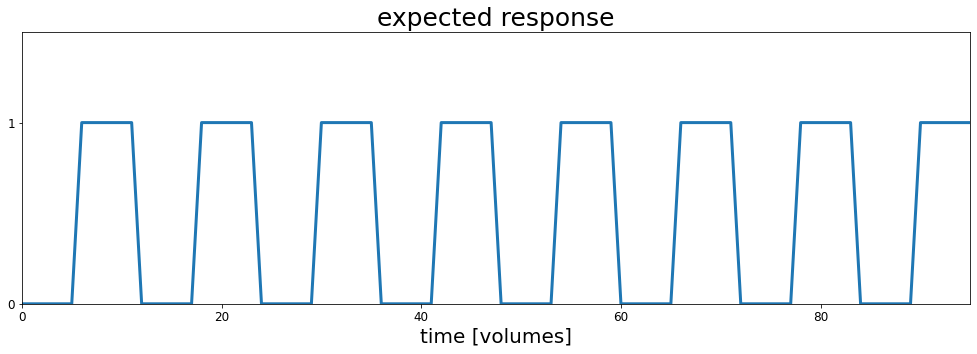

In [19]:
# Create the design matrix
constant = np.ones(acq_num)
rest     = np.zeros(block_size)
stim     = np.ones(block_size)
block    = np.concatenate((rest, stim), axis=0)
predicted_response = np.tile(block, int(block_total/2))

design_matrix = np.array((constant, predicted_response))

# Create the plots
fig = plt.figure(figsize=(17, 5))


plt.plot(design_matrix[1], lw=3)
plt.xlim(0, acq_num-1)
plt.ylim(0, 1.5)
plt.title('expected response', fontsize=25)
plt.yticks([0,1])
plt.xlabel('time [volumes]', fontsize=20)
plt.tick_params(labelsize=12)
plt.tick_params(labelsize=12)

fig.subplots_adjust(wspace=0, hspace=0.5)
plt.show()

This means, we can treat each voxel in the scan as a value of a time series, and work out the correlation of each with the expected response above. Thus, the higher the correlation, the more likely that the regions represented by voxels are responsible for the auditory processing. 

Now, let us plot the a voxels signal over the 96 volumes with our expected response together:

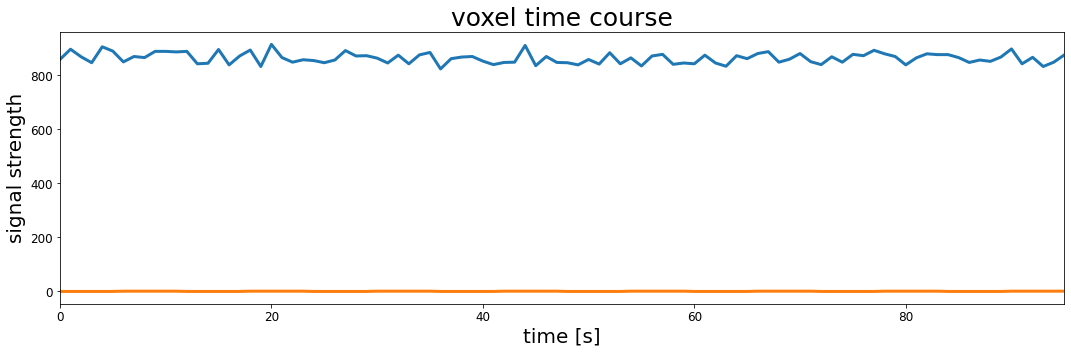

In [20]:

fig, ax = plt.subplots(1, 1, figsize=[18, 5])

# Plot the timecourse of a random voxel
ax.plot(transversal[30, 30, 35, :], lw=3)
ax.set_xlim([0, transversal.shape[3]-1])
ax.plot(design_matrix[1], lw=3)
ax.set_xlabel('time [s]', fontsize=20)
ax.set_ylabel('signal strength', fontsize=20)
ax.set_title('voxel time course', fontsize=25)
ax.tick_params(labelsize=12)

Oops. We cannot effectively visualise this as the signal strength is magnitudes larger than 1, but we can scale down the signal strengths by performing the min max scaling. 

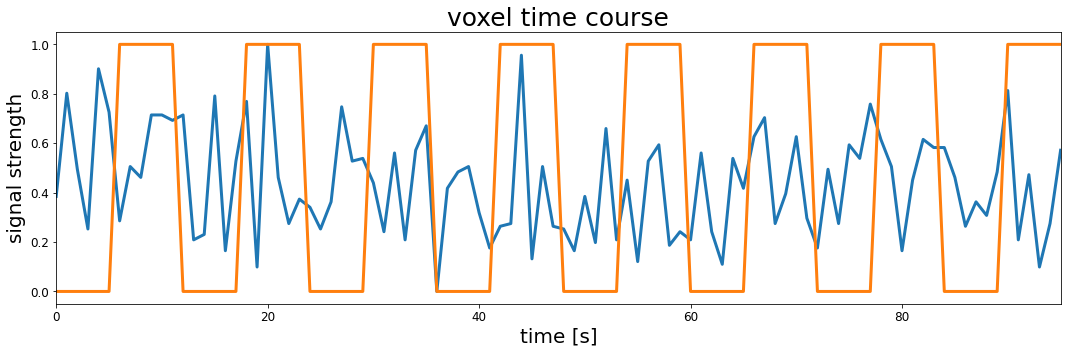

In [21]:
# a self implementation as an example
scaled_transversal = (transversal[30, 30, 35, :] - min(transversal[30, 30, 35, :])) / (max(transversal[30, 30, 35, :]) - min(transversal[30, 30, 35, :]))

fig, ax = plt.subplots(1, 1, figsize=[18, 5])

# Plot the timecourse of a random voxel
ax.plot(scaled_transversal, lw=3)
ax.set_xlim([0, transversal.shape[3]-1])
ax.plot(design_matrix[1], lw=3)
ax.set_xlabel('time [s]', fontsize=20)
ax.set_ylabel('signal strength', fontsize=20)
ax.set_title('voxel time course', fontsize=25)
ax.tick_params(labelsize=12)

From the graph above, we can see that this randomly chosen voxel doesn't not appear to be highly correlated with our expected response, but this is only one voxel! To get a bigger picture, we must calculate the correlation of each voxel with the expected response. For simplicity, we will only look at one slice for now (slice 36 is chosen).

In [22]:
# Calculate the correlation coefficients
c = np.corrcoef(design_matrix[1,:], data)[1:,0]

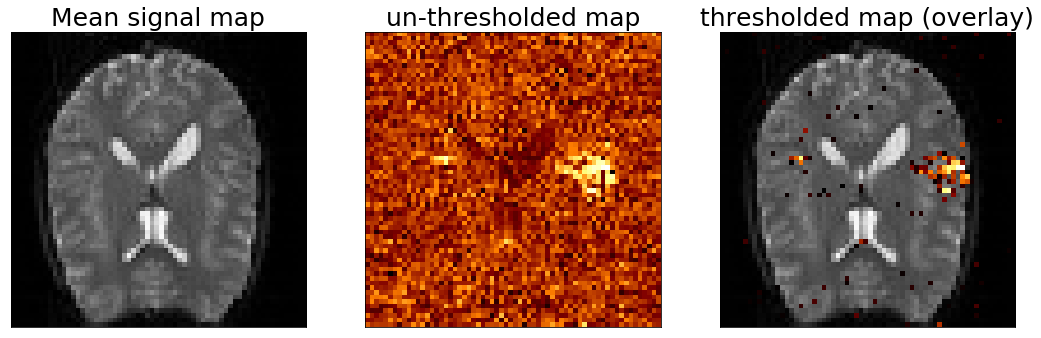

In [28]:
corr = c.reshape(x_size, y_size)
map = corr.copy()
map[map < 0.2] = np.nan

# Ok now lets visualize all the maps
fig, ax = plt.subplots(1,3,figsize=(18, 6))

# Create the plots
ax[0].imshow(data.mean(1).reshape(64, 64), cmap='gray')
ax[0].set_title('Mean signal map', fontsize=25)
ax[0].set_xticks([])
ax[0].set_yticks([])

ax[1].imshow(corr,  cmap='afmhot')
ax[1].set_title('un-thresholded map', fontsize=25)
ax[1].set_xticks([])
ax[1].set_yticks([])

ax[2].imshow(data.mean(1).reshape(64, 64), cmap='gray')
ax[2].imshow(map, cmap='afmhot')
ax[2].set_title('thresholded map (overlay)', fontsize=25)
ax[2].set_yticks([])
ax[2].set_xticks([])
ax[2].set_yticks([])

From the plots above, we can see that the certain areas of the brain do emit a higher correlation with our expected response, thus showing the regions of the brain responsible for auditory processing. Indeed the areas with the highest correlations are that is where the auditory cortex is!

An image showing the location of the auditory cortex of the brain


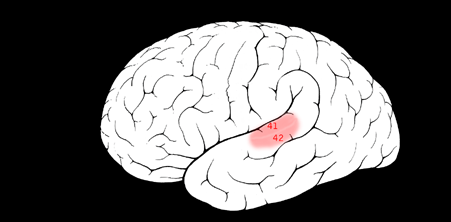

In [34]:
from IPython.display import Image
print("An image showing the location of the auditory cortex of the brain")
Image(filename='Screenshot.png')